In [1]:
import pandas as pd

In [2]:
import pandas as pd

# --- Carga de Datos ---
# Asegúrate de que los archivos CSV estén en la misma carpeta o proporciona la ruta correcta.
# Por ejemplo: pd.read_csv('ruta/a/tus/datos/olist_orders_dataset.csv')

try:
    orders = pd.read_csv('olist_orders_dataset.csv')
    order_items = pd.read_csv('olist_order_items_dataset.csv')
    products = pd.read_csv('olist_products_dataset.csv')
    sellers = pd.read_csv('olist_sellers_dataset.csv')
    payments = pd.read_csv('olist_order_payments_dataset.csv')
    reviews = pd.read_csv('olist_order_reviews_dataset.csv')
    customers = pd.read_csv('olist_customers_dataset.csv')
    geolocation = pd.read_csv('olist_geolocation_dataset.csv')
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo {e.filename}. Asegúrate de que los nombres de archivo sean correctos y estén en la ubicación adecuada.")
    # Detener la ejecución si los archivos no se encuentran
    exit()


# --- Proceso de Unión (Merge) ---

# 1. Unir orders con order_items usando 'order_id'
merged_df = pd.merge(orders, order_items, on='order_id', how='left')

# 2. Unir con products usando 'product_id'
merged_df = pd.merge(merged_df, products, on='product_id', how='left')

# 3. Unir con sellers usando 'seller_id'
merged_df = pd.merge(merged_df, sellers, on='seller_id', how='left')

# 4. Unir con payments usando 'order_id'
merged_df = pd.merge(merged_df, payments, on='order_id', how='left')

# 5. Unir con reviews usando 'order_id'
merged_df = pd.merge(merged_df, reviews, on='order_id', how='left')

# 6. Unir con customers usando 'customer_id'
merged_df = pd.merge(merged_df, customers, on='customer_id', how='left')

# Agrupar por prefijo de código postal y calcular la media para evitar duplicados masivos
geolocation_agg = geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

# Renombrar columnas para la unión
geolocation_agg.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix'}, inplace=True)

# Unir la geolocalización del cliente
merged_df = pd.merge(
    merged_df,
    geolocation_agg,
    on='customer_zip_code_prefix',
    how='left'
)

# Renombrar columnas para la unión con la geolocalización del vendedor
geolocation_agg.rename(columns={'customer_zip_code_prefix': 'seller_zip_code_prefix'}, inplace=True)

# Unir la geolocalización del vendedor
merged_df = pd.merge(
    merged_df,
    geolocation_agg.add_suffix('_seller'),  # Añadir sufijo para diferenciar lat/lng de cliente y vendedor
    left_on='seller_zip_code_prefix',
    right_on='seller_zip_code_prefix_seller',
    how='left'
)
merged_df.drop(columns=['seller_zip_code_prefix_seller'], inplace=True)

In [3]:
merged_df["order_status"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [4]:
merged_df["payment_type"].unique()

array(['credit_card', 'voucher', 'boleto', 'debit_card', 'not_defined',
       nan], dtype=object)

In [5]:
# 1. Diccionario de traducción
traduccion_categorias = {
    'utilidades_domesticas': 'Artículos para el Hogar',
    'perfumaria': 'Perfumería',
    'automotivo': 'Automotriz',
    'pet_shop': 'Tienda de Mascotas',
    'papelaria': 'Papelería',
    'moveis_decoracao': 'Muebles y Decoración',
    'moveis_escritorio': 'Muebles de Oficina',
    'ferramentas_jardim': 'Herramientas de Jardín',
    'informatica_acessorios': 'Informática y Accesorios',
    'cama_mesa_banho': 'Cama, Mesa y Baño',
    'brinquedos': 'Juguetes',
    'construcao_ferramentas_construcao': 'Herramientas de Construcción',
    'telefonia': 'Telefonía',
    'beleza_saude': 'Belleza y Salud',
    'eletronicos': 'Electrónicos',
    'bebes': 'Bebés',
    'cool_stuff': 'Artículos Geniales',
    'relogios_presentes': 'Relojes y Regalos',
    'climatizacao': 'Climatización',
    'esporte_lazer': 'Deporte y Ocio',
    'livros_interesse_geral': 'Libros de Interés General',
    'eletroportateis': 'Electrodomésticos Portátiles',
    'alimentos': 'Alimentos',
    'malas_acessorios': 'Maletas y Accesorios',
    'fashion_underwear_e_moda_praia': 'Ropa Interior y Moda de Playa',
    'artigos_de_natal': 'Artículos de Navidad',
    'fashion_bolsas_e_acessorios': 'Bolsos y Accesorios de Moda',
    'instrumentos_musicais': 'Instrumentos Musicales',
    'construcao_ferramentas_iluminacao': 'Iluminación para Construcción',
    'livros_tecnicos': 'Libros Técnicos',
    'construcao_ferramentas_jardim': 'Herramientas para Jardinería',
    'eletrodomesticos': 'Electrodomésticos',
    'market_place': 'Market Place',
    'agro_industria_e_comercio': 'Agroindustria y Comercio',
    'artigos_de_festas': 'Artículos de Fiesta',
    'casa_conforto': 'Confort para el Hogar',
    'cds_dvds_musicais': 'CDs y DVDs de Música',
    'industria_comercio_e_negocios': 'Industria, Comercio y Negocios',
    'consoles_games': 'Consolas y Videojuegos',
    'moveis_quarto': 'Muebles de Dormitorio',
    'construcao_ferramentas_seguranca': 'Seguridad para Construcción',
    'telefonia_fixa': 'Telefonía Fija',
    'bebidas': 'Bebidas',
    'moveis_cozinha_area_de_servico_jantar_e_jardim': 'Muebles de Cocina, Lavandería, Comedor y Jardín',
    'fashion_calcados': 'Calzado de Moda',
    'casa_construcao': 'Casa y Construcción',
    'audio': 'Audio',
    'eletrodomesticos_2': 'Electrodomésticos 2',
    'fashion_roupa_masculina': 'Ropa de Hombre',
    'cine_foto': 'Cine y Fotografía',
    'moveis_sala': 'Muebles de Sala',
    'artes': 'Arte',
    'alimentos_bebidas': 'Alimentos y Bebidas',
    'tablets_impressao_imagem': 'Tablets e Impresión de Imágenes',
    'fashion_esporte': 'Moda Deportiva',
    'portateis_cozinha_e_preparadores_de_alimentos': 'Portátiles de Cocina y Preparadores de Alimentos',
    'la_cuisine': 'Cocina',
    'flores': 'Flores',
    'pcs': 'Computadoras (PCs)',
    'casa_conforto_2': 'Confort para el Hogar 2',
    'portateis_casa_forno_e_cafe': 'Portátiles para el Hogar, Horno y Café',
    'dvds_blu_ray': 'DVDs y Blu-ray',
    'pc_gamer': 'PC Gamer',
    'construcao_ferramentas_ferramentas': 'Herramientas de Construcción (General)',
    'fashion_roupa_feminina': 'Ropa de Mujer',
    'moveis_colchao_e_estofado': 'Muebles, Colchones y Tapizados',
    'sinalizacao_e_seguranca': 'Señalización y Seguridad',
    'fraldas_higiene': 'Pañales e Higiene',
    'livros_importados': 'Libros Importados',
    'fashion_roupa_infanto_juvenil': 'Ropa Infantil y Juvenil',
    'musica': 'Música',
    'artes_e_artesanato': 'Arte y Artesanía',
    'seguros_e_servicos': 'Seguros y Servicios'
}

merged_df['product_category_name_es'] = merged_df['product_category_name'].map(traduccion_categorias)

# --- Diccionarios de Traducción ---

# Para el estado del pedido
traduccion_status = {
    'delivered': 'Entregado',
    'invoiced': 'Facturado',
    'shipped': 'Enviado',
    'processing': 'Procesando',
    'unavailable': 'No disponible',
    'canceled': 'Cancelado',
    'created': 'Creado',
    'approved': 'Aprobado'
}

# Para el tipo de pago
traduccion_pago = {
    'credit_card': 'Tarjeta de crédito',
    'voucher': 'Cupón',
    'boleto': 'Boleto bancario',
    'debit_card': 'Tarjeta de débito',
    'not_defined': 'No definido'
}

# --- Aplicar Traducciones ---

merged_df['order_status_es'] = merged_df['order_status'].map(traduccion_status)
merged_df['payment_type_es'] = merged_df['payment_type'].map(traduccion_pago)


# --- Verificación de las traducciones ---
print("--- Verificación de Traducciones ---")
print(merged_df[['order_status', 'order_status_es', 'payment_type', 'payment_type_es']].head())


# --- Lista de columnas de fecha a convertir ---
columnas_fecha = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date',
    'review_creation_date',
    'review_answer_timestamp'
]

# --- Bucle para convertir cada columna ---
print("\n--- Convirtiendo columnas a datetime ---")
for columna in columnas_fecha:
    # Usamos errors='coerce' para que cualquier valor que no se pueda convertir
    # se transforme en NaT (Not a Time), evitando errores.
    merged_df[columna] = pd.to_datetime(merged_df[columna], errors='coerce')
    print(f"Columna '{columna}' convertida.")

# --- Verificación final de los tipos de datos ---
print("\n--- Resumen de los nuevos tipos de datos (Dtypes) ---")
# El resultado mostrará las columnas de fecha como 'datetime64[ns]'
merged_df.info()

--- Verificación de Traducciones ---
  order_status order_status_es payment_type     payment_type_es
0    delivered       Entregado  credit_card  Tarjeta de crédito
1    delivered       Entregado      voucher               Cupón
2    delivered       Entregado      voucher               Cupón
3    delivered       Entregado       boleto     Boleto bancario
4    delivered       Entregado  credit_card  Tarjeta de crédito

--- Convirtiendo columnas a datetime ---
Columna 'order_purchase_timestamp' convertida.
Columna 'order_approved_at' convertida.
Columna 'order_delivered_carrier_date' convertida.
Columna 'order_delivered_customer_date' convertida.
Columna 'order_estimated_delivery_date' convertida.
Columna 'shipping_limit_date' convertida.
Columna 'review_creation_date' convertida.
Columna 'review_answer_timestamp' convertida.

--- Resumen de los nuevos tipos de datos (Dtypes) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 46 columns)

In [6]:

# Columnas originales que ya no necesitamos
columnas_a_eliminar = [
    'product_category_name',
    'order_status',
    'payment_type'
]

# Diccionario para renombrar las columnas traducidas
columnas_a_renombrar = {
    'product_category_name_es': 'product_category_name',
    'order_status_es': 'order_status',
    'payment_type_es': 'payment_type'
}


# --- Aplicar los cambios ---

# 1. Eliminar las columnas originales
merged_df.drop(columns=columnas_a_eliminar, inplace=True)
print(f"Se eliminaron las columnas: {columnas_a_eliminar}")

# 2. Renombrar las columnas traducidas
merged_df.rename(columns=columnas_a_renombrar, inplace=True)
print(f"Se renombraron las columnas traducidas.")


# --- Verificación Final ---
print("\n--- Verificando el estado final del DataFrame ---")
print("Primeras filas con las columnas ya limpias y traducidas:")
print(merged_df[['order_status', 'payment_type', 'product_category_name']].head())

print("\nInformación final del DataFrame:")
# Ahora deberías tener 43 columnas en total y las columnas de interés
# con sus nombres originales pero contenido en español.
merged_df.info()

Se eliminaron las columnas: ['product_category_name', 'order_status', 'payment_type']
Se renombraron las columnas traducidas.

--- Verificando el estado final del DataFrame ---
Primeras filas con las columnas ya limpias y traducidas:
  order_status        payment_type    product_category_name
0    Entregado  Tarjeta de crédito  Artículos para el Hogar
1    Entregado               Cupón  Artículos para el Hogar
2    Entregado               Cupón  Artículos para el Hogar
3    Entregado     Boleto bancario               Perfumería
4    Entregado  Tarjeta de crédito               Automotriz

Información final del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  obje

In [7]:
# Diccionario para traducir los NOMBRES DE LAS COLUMNAS
traduccion_nombres_columnas = {
    'order_id': 'id_pedido',
    'customer_id': 'id_cliente',
    'order_status': 'estado_pedido',
    'order_purchase_timestamp': 'fecha_compra',
    'order_approved_at': 'fecha_aprobacion_pedido',
    'order_delivered_carrier_date': 'fecha_envio_transportista',
    'order_delivered_customer_date': 'fecha_entrega_cliente',
    'order_estimated_delivery_date': 'fecha_estimada_entrega',
    'order_item_id': 'id_item_pedido',
    'product_id': 'id_producto',
    'seller_id': 'id_vendedor',
    'shipping_limit_date': 'fecha_limite_envio',
    'price': 'precio',
    'freight_value': 'valor_flete',
    'product_name_lenght': 'longitud_nombre_producto',
    'product_description_lenght': 'longitud_descripcion_producto',
    'product_photos_qty': 'cantidad_fotos_producto',
    'product_weight_g': 'peso_producto_g',
    'product_length_cm': 'longitud_producto_cm',
    'product_height_cm': 'altura_producto_cm',
    'product_width_cm': 'ancho_producto_cm',
    'seller_zip_code_prefix': 'cp_vendedor',
    'seller_city': 'ciudad_vendedor',
    'seller_state': 'estado_vendedor',
    'payment_sequential': 'secuencial_pago',
    'payment_installments': 'cuotas_pago',
    'payment_value': 'valor_pago',
    'review_id': 'id_reseña',
    'review_score': 'puntuacion_reseña',
    'review_comment_title': 'titulo_reseña',
    'review_comment_message': 'mensaje_reseña',
    'review_creation_date': 'fecha_creacion_reseña',
    'review_answer_timestamp': 'fecha_respuesta_reseña',
    'customer_unique_id': 'id_unico_cliente',
    'customer_zip_code_prefix': 'cp_cliente',
    'customer_city': 'ciudad_cliente',
    'customer_state': 'estado_cliente',
    'geolocation_lat': 'latitud_cliente',
    'geolocation_lng': 'longitud_cliente',
    'geolocation_lat_seller': 'latitud_vendedor',
    'geolocation_lng_seller': 'longitud_vendedor',
    'product_category_name': 'nombre_categoria_producto',
    'payment_type': 'tipo_pago'
}

# Aplicar el renombrado de columnas al DataFrame
merged_df.rename(columns=traduccion_nombres_columnas, inplace=True)

# --- Verificación Final ---
print("¡Columnas renombradas a español!")
print("Mostrando los nuevos nombres de las columnas:")

# Muestra todas las columnas del DataFrame en formato de lista
print(merged_df.columns.tolist())

# Muestra las primeras filas con los nuevos nombres de columna
print("\nVista previa del DataFrame con encabezados en español:")
merged_df.head()

¡Columnas renombradas a español!
Mostrando los nuevos nombres de las columnas:
['id_pedido', 'id_cliente', 'fecha_compra', 'fecha_aprobacion_pedido', 'fecha_envio_transportista', 'fecha_entrega_cliente', 'fecha_estimada_entrega', 'id_item_pedido', 'id_producto', 'id_vendedor', 'fecha_limite_envio', 'precio', 'valor_flete', 'longitud_nombre_producto', 'longitud_descripcion_producto', 'cantidad_fotos_producto', 'peso_producto_g', 'longitud_producto_cm', 'altura_producto_cm', 'ancho_producto_cm', 'cp_vendedor', 'ciudad_vendedor', 'estado_vendedor', 'secuencial_pago', 'cuotas_pago', 'valor_pago', 'id_reseña', 'puntuacion_reseña', 'titulo_reseña', 'mensaje_reseña', 'fecha_creacion_reseña', 'fecha_respuesta_reseña', 'id_unico_cliente', 'cp_cliente', 'ciudad_cliente', 'estado_cliente', 'latitud_cliente', 'longitud_cliente', 'latitud_vendedor', 'longitud_vendedor', 'nombre_categoria_producto', 'estado_pedido', 'tipo_pago']

Vista previa del DataFrame con encabezados en español:


,id_pedido,id_cliente,fecha_compra,fecha_aprobacion_pedido,fecha_envio_transportista,fecha_entrega_cliente,fecha_estimada_entrega,id_item_pedido,id_producto,id_vendedor,...,cp_cliente,ciudad_cliente,estado_cliente,latitud_cliente,longitud_cliente,latitud_vendedor,longitud_vendedor,nombre_categoria_producto,estado_pedido,tipo_pago
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,3149,sao paulo,SP,-23.576983,-46.587161,-23.680729,-46.444238,Artículos para el Hogar,Entregado,Tarjeta de crédito
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,3149,sao paulo,SP,-23.576983,-46.587161,-23.680729,-46.444238,Artículos para el Hogar,Entregado,Cupón
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,3149,sao paulo,SP,-23.576983,-46.587161,-23.680729,-46.444238,Artículos para el Hogar,Entregado,Cupón
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,...,47813,barreiras,BA,-12.177924,-44.660711,-19.807681,-43.980427,Perfumería,Entregado,Boleto bancario
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,...,75265,vianopolis,GO,-16.745150,-48.514783,-21.363502,-48.229601,Automotriz,Entregado,Tarjeta de crédito


In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   id_pedido                      119143 non-null  object        
 1   id_cliente                     119143 non-null  object        
 2   fecha_compra                   119143 non-null  datetime64[ns]
 3   fecha_aprobacion_pedido        118966 non-null  datetime64[ns]
 4   fecha_envio_transportista      117057 non-null  datetime64[ns]
 5   fecha_entrega_cliente          115722 non-null  datetime64[ns]
 6   fecha_estimada_entrega         119143 non-null  datetime64[ns]
 7   id_item_pedido                 118310 non-null  float64       
 8   id_producto                    118310 non-null  object        
 9   id_vendedor                    118310 non-null  object        
 10  fecha_limite_envio             118310 non-null  datetime64[ns]
 11  

In [9]:
merged_df[["precio" , "valor_flete","valor_pago","cuotas_pago","cp_cliente"]].describe()

,precio,valor_flete,valor_pago,cuotas_pago,cp_cliente
count,118310.000000,118310.000000,119140.000000,119140.000000,119143.000000
mean,120.646603,20.032387,172.735135,2.941246,35033.451298
std,184.109691,15.836850,267.776077,2.777848,29823.198969
min,0.850000,0.000000,0.000000,0.000000,1003.000000
25%,39.900000,13.080000,60.850000,1.000000,11250.000000
50%,74.900000,16.280000,108.160000,2.000000,24240.000000
75%,134.900000,21.180000,189.240000,4.000000,58475.000000
max,6735.000000,409.680000,13664.080000,24.000000,99990.000000


In [10]:
merged_df.to_csv('olist_merged_dataset.csv', index=False)

In [11]:
merged_df.columns

Index(['id_pedido', 'id_cliente', 'fecha_compra', 'fecha_aprobacion_pedido',
       'fecha_envio_transportista', 'fecha_entrega_cliente',
       'fecha_estimada_entrega', 'id_item_pedido', 'id_producto',
       'id_vendedor', 'fecha_limite_envio', 'precio', 'valor_flete',
       'longitud_nombre_producto', 'longitud_descripcion_producto',
       'cantidad_fotos_producto', 'peso_producto_g', 'longitud_producto_cm',
       'altura_producto_cm', 'ancho_producto_cm', 'cp_vendedor',
       'ciudad_vendedor', 'estado_vendedor', 'secuencial_pago', 'cuotas_pago',
       'valor_pago', 'id_reseña', 'puntuacion_reseña', 'titulo_reseña',
       'mensaje_reseña', 'fecha_creacion_reseña', 'fecha_respuesta_reseña',
       'id_unico_cliente', 'cp_cliente', 'ciudad_cliente', 'estado_cliente',
       'latitud_cliente', 'longitud_cliente', 'latitud_vendedor',
       'longitud_vendedor', 'nombre_categoria_producto', 'estado_pedido',
       'tipo_pago'],
      dtype='object')

In [12]:
merged_df.isnull().sum().sort_values(ascending=False)

titulo_reseña                    105154
mensaje_reseña                    68898
fecha_entrega_cliente              3421
longitud_nombre_producto           2542
longitud_descripcion_producto      2542
nombre_categoria_producto          2542
cantidad_fotos_producto            2542
fecha_envio_transportista          2086
latitud_vendedor                   1098
longitud_vendedor                  1098
fecha_creacion_reseña               997
fecha_respuesta_reseña              997
puntuacion_reseña                   997
id_reseña                           997
longitud_producto_cm                853
ancho_producto_cm                   853
altura_producto_cm                  853
peso_producto_g                     853
cp_vendedor                         833
id_producto                         833
ciudad_vendedor                     833
precio                              833
estado_vendedor                     833
valor_flete                         833
id_item_pedido                      833


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

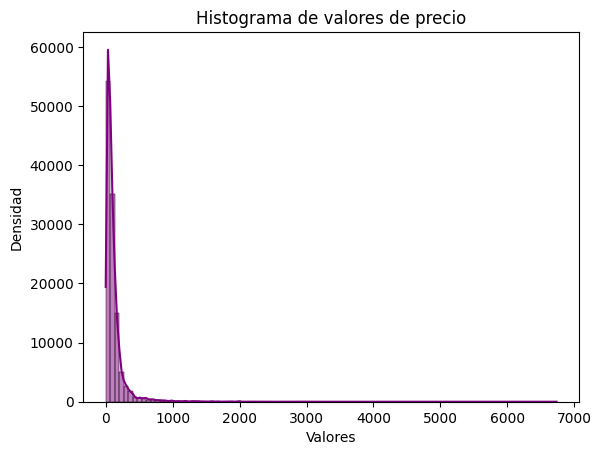

In [14]:
sns.histplot(data=merged_df, x='precio', bins=100 , kde = True , color="purple")
plt.title('Histograma de valores de precio')
plt.xlabel('Valores')
plt.ylabel('Densidad')

plt.show()

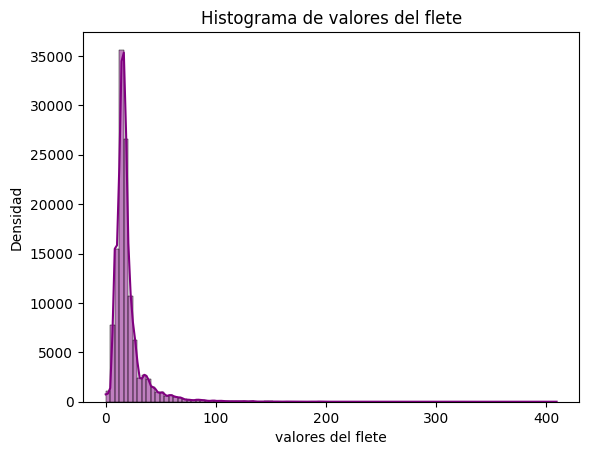

In [15]:
sns.histplot(data=merged_df, x='valor_flete', bins=100 , kde = True , color="purple")
plt.title('Histograma de valores del flete')
plt.xlabel('valores del flete')
plt.ylabel('Densidad')

plt.show()


Número de valores nulos encontrados en 'cuotas_pago': 3


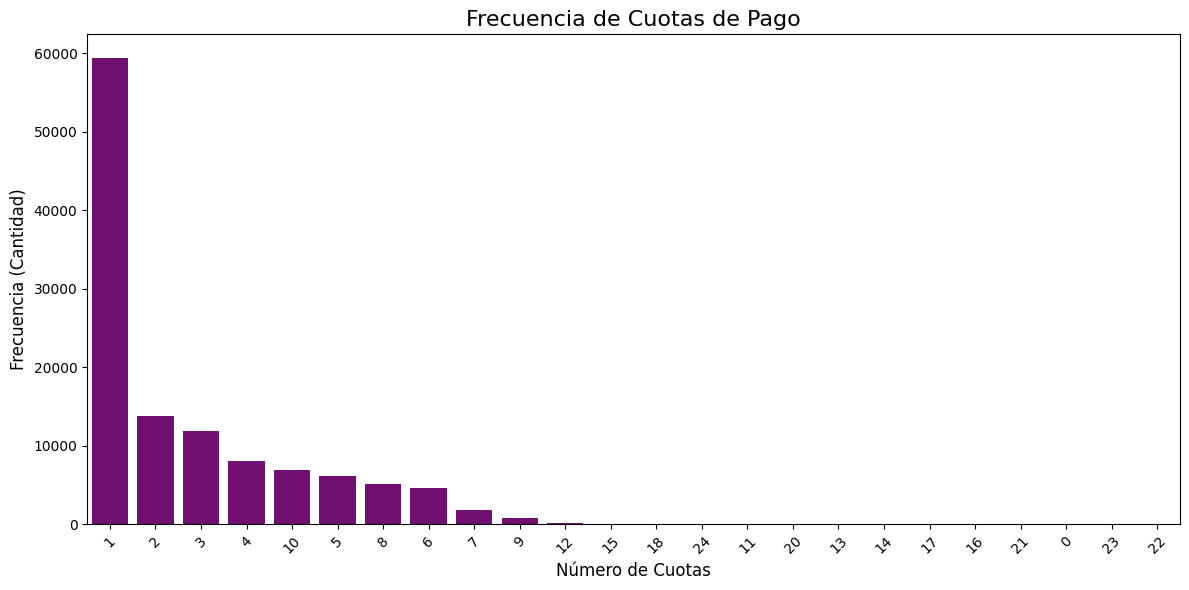

In [16]:
nulos = merged_df['cuotas_pago'].isnull().sum()
print(f"Número de valores nulos encontrados en 'cuotas_pago': {nulos}")

# --- PASO 2: LIMPIAR LOS DATOS (SOLUCIÓN AL ERROR) ---

# Primero, rellena los valores nulos (NaN) con 0.
# Luego, redondea y convierte a entero.
# Todo en una sola línea:
merged_df['cuotas_pago'] = merged_df['cuotas_pago'].fillna(0).round().astype(int)


# --- PASO 3: CREAR EL GRÁFICO MEJORADO ---
# (El resto del código sigue igual que antes)

plt.figure(figsize=(12, 6))

orden_barras = merged_df['cuotas_pago'].value_counts().index
sns.countplot(data=merged_df, x='cuotas_pago', color="purple", order=orden_barras)

plt.title('Frecuencia de Cuotas de Pago', fontsize=16)
plt.xlabel('Número de Cuotas', fontsize=12)
plt.ylabel('Frecuencia (Cantidad)', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

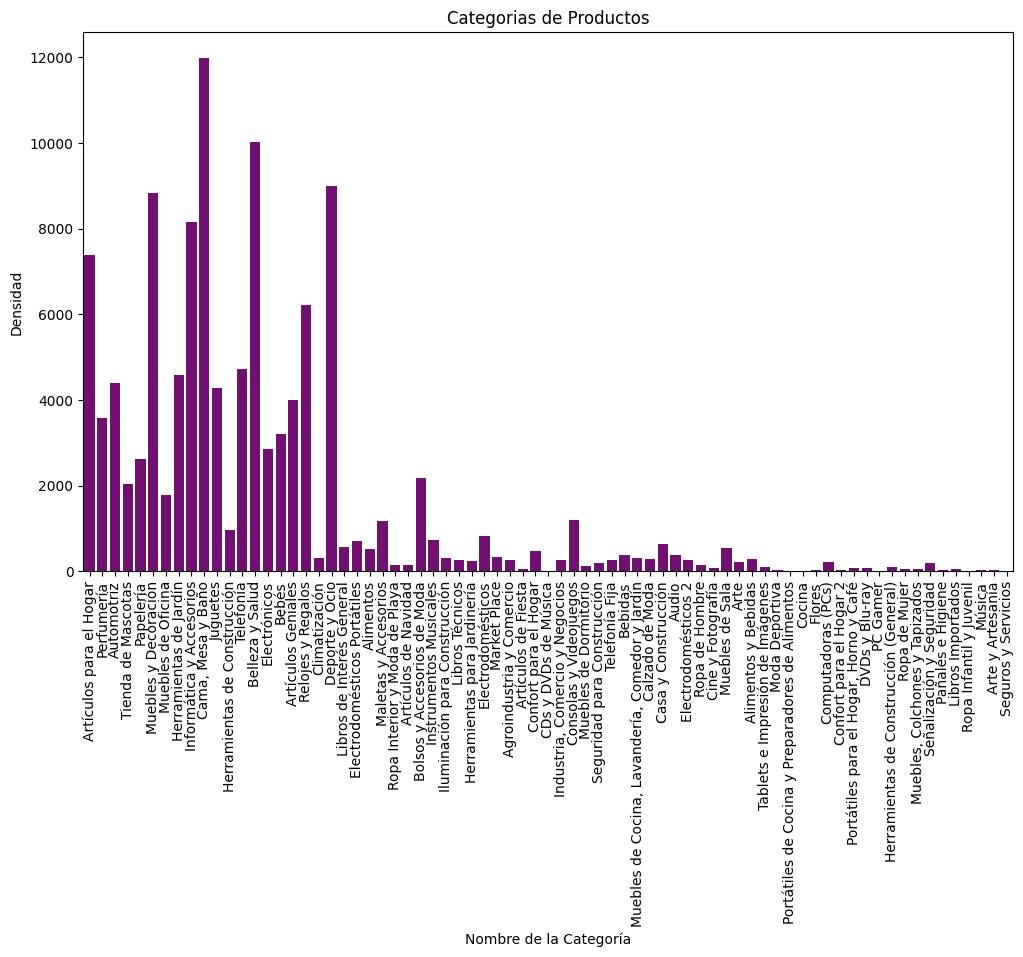

In [17]:
plt.figure(figsize=(12, 7))
sns.countplot(data=merged_df, x='nombre_categoria_producto', color="purple")
plt.title('Categorias de Productos')
plt.xlabel('Nombre de la Categoría')
plt.ylabel('Densidad')
plt.xticks(rotation=90)
plt.show()


In [18]:
display(merged_df["nombre_categoria_producto"].value_counts())

nombre_categoria_producto
Cama, Mesa y Baño                                   11988
Belleza y Salud                                     10032
Deporte y Ocio                                       9004
Muebles y Decoración                                 8832
Informática y Accesorios                             8150
                                                    ...  
Portátiles de Cocina y Preparadores de Alimentos       15
CDs y DVDs de Música                                   14
PC Gamer                                               10
Ropa Infantil y Juvenil                                 8
Seguros y Servicios                                     2
Name: count, Length: 73, dtype: int64

In [19]:
merged_df["tipo_pago"].value_counts()

tipo_pago
Tarjeta de crédito    87776
Boleto bancario       23190
Cupón                  6465
Tarjeta de débito      1706
No definido               3
Name: count, dtype: int64

In [20]:
merged_df["puntuacion_reseña"].value_counts()

puntuacion_reseña
5.0    66343
4.0    22319
1.0    15428
3.0     9894
2.0     4162
Name: count, dtype: int64

In [21]:
merged_df.columns

Index(['id_pedido', 'id_cliente', 'fecha_compra', 'fecha_aprobacion_pedido',
       'fecha_envio_transportista', 'fecha_entrega_cliente',
       'fecha_estimada_entrega', 'id_item_pedido', 'id_producto',
       'id_vendedor', 'fecha_limite_envio', 'precio', 'valor_flete',
       'longitud_nombre_producto', 'longitud_descripcion_producto',
       'cantidad_fotos_producto', 'peso_producto_g', 'longitud_producto_cm',
       'altura_producto_cm', 'ancho_producto_cm', 'cp_vendedor',
       'ciudad_vendedor', 'estado_vendedor', 'secuencial_pago', 'cuotas_pago',
       'valor_pago', 'id_reseña', 'puntuacion_reseña', 'titulo_reseña',
       'mensaje_reseña', 'fecha_creacion_reseña', 'fecha_respuesta_reseña',
       'id_unico_cliente', 'cp_cliente', 'ciudad_cliente', 'estado_cliente',
       'latitud_cliente', 'longitud_cliente', 'latitud_vendedor',
       'longitud_vendedor', 'nombre_categoria_producto', 'estado_pedido',
       'tipo_pago'],
      dtype='object')

C:\Users\Diego\AppData\Local\Temp\ipykernel_6872\2105121133.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuotas_pago', y='precio', data=merged_df, palette='viridis')


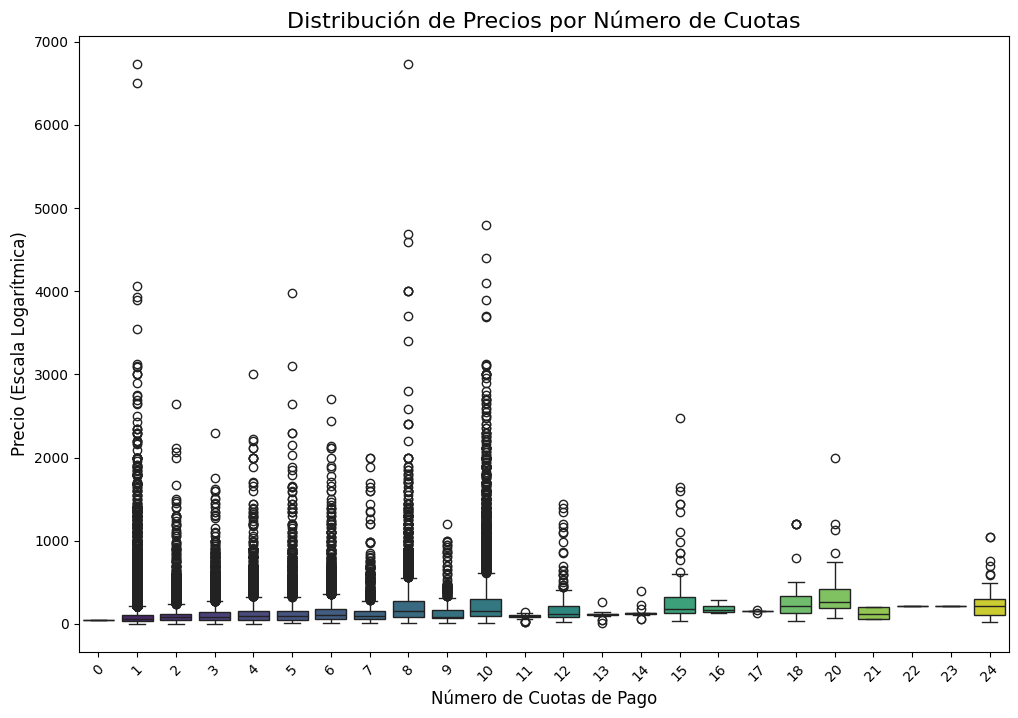

In [22]:
plt.figure(figsize=(12, 8))

# Creamos el Box Plot
sns.boxplot(x='cuotas_pago', y='precio', data=merged_df, palette='viridis')

#plt.yscale('log')

plt.title('Distribución de Precios por Número de Cuotas', fontsize=16)
plt.xlabel('Número de Cuotas de Pago', fontsize=12)
plt.ylabel('Precio (Escala Logarítmica)', fontsize=12)
plt.xticks(rotation=45) # Rotar etiquetas si se superponen
plt.show()

C:\Users\Diego\AppData\Local\Temp\ipykernel_6872\3539192392.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuotas_pago', y='precio', data=merged_df, palette='viridis')


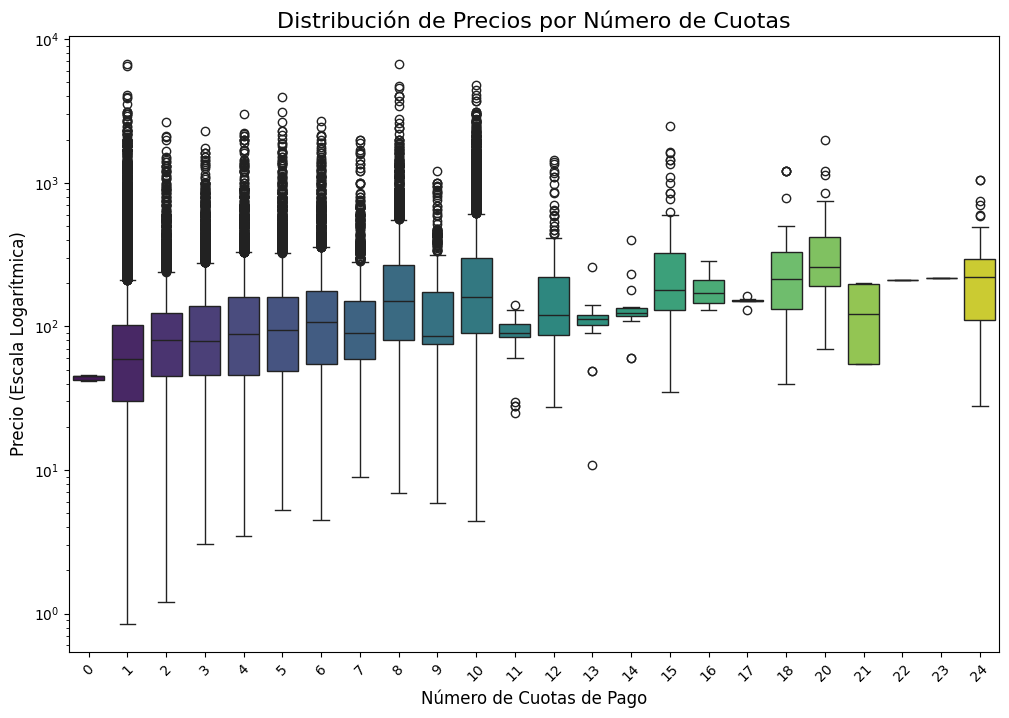

In [23]:
plt.figure(figsize=(12, 8))

# Creamos el Box Plot
sns.boxplot(x='cuotas_pago', y='precio', data=merged_df, palette='viridis')

plt.yscale('log')

plt.title('Distribución de Precios por Número de Cuotas', fontsize=16)
plt.xlabel('Número de Cuotas de Pago', fontsize=12)
plt.ylabel('Precio (Escala Logarítmica)', fontsize=12)
plt.xticks(rotation=45) # Rotar etiquetas si se superponen
plt.show()

In [24]:
merged_df['volumen_cm3'] = merged_df['longitud_producto_cm'] * merged_df['altura_producto_cm'] * merged_df['ancho_producto_cm']


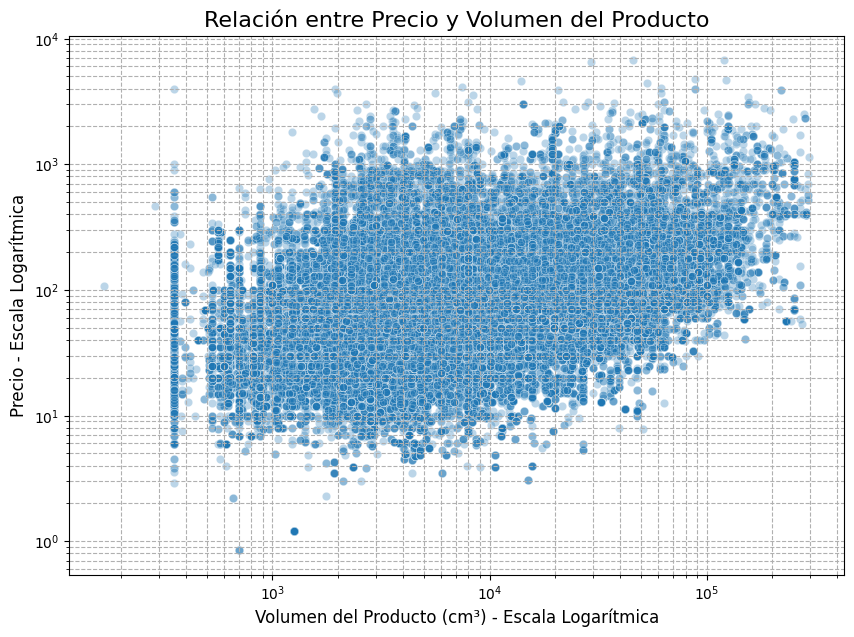

In [25]:
df_plot = merged_df[(merged_df['precio'] > 0) & (merged_df['volumen_cm3'] > 0)].copy()

plt.figure(figsize=(10, 7))

# Creamos el gráfico de dispersión
sns.scatterplot(data=df_plot, x='volumen_cm3', y='precio', alpha=0.3)

# --- La Clave: Escala Log-Log ---
plt.xscale('log')
plt.yscale('log')

# --- Títulos y Etiquetas Correctos ---
plt.title('Relación entre Precio y Volumen del Producto', fontsize=16)
plt.xlabel('Volumen del Producto (cm³) - Escala Logarítmica', fontsize=12)
plt.ylabel('Precio - Escala Logarítmica', fontsize=12)
plt.grid(True, which="both", ls="--")

plt.show()

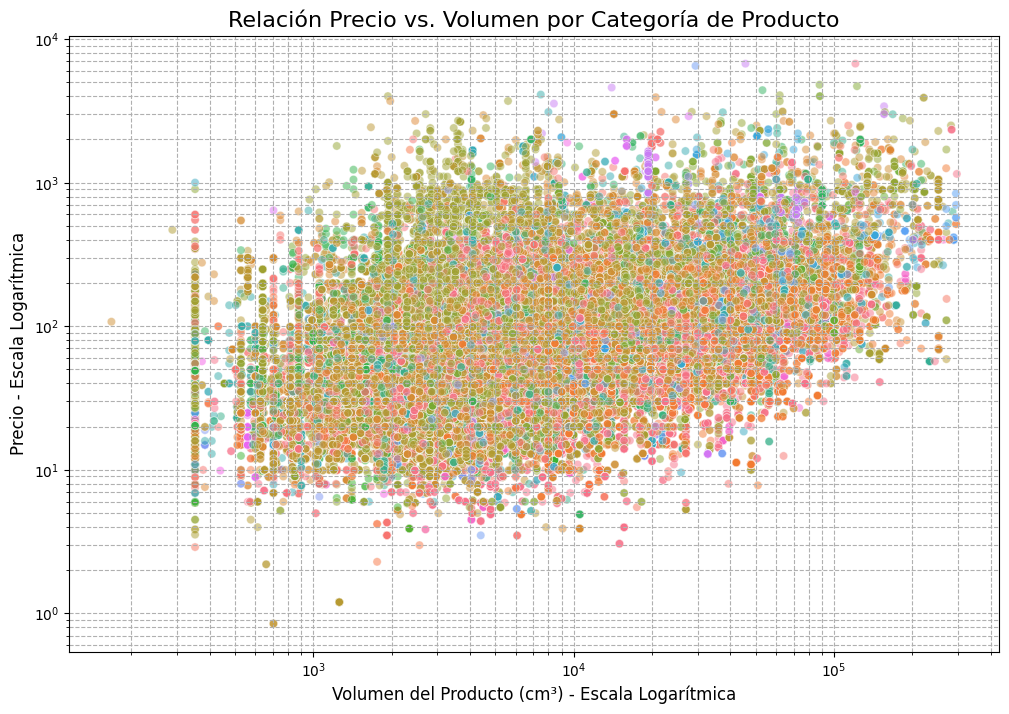

In [26]:
plt.figure(figsize=(12, 8))

# Usamos el parámetro 'hue' para colorear por categoría
sns.scatterplot(data=df_plot, x='volumen_cm3', y='precio', alpha=0.5, hue='nombre_categoria_producto', legend=False) # legend=False para no saturar el gráfico

plt.xscale('log')
plt.yscale('log')

plt.title('Relación Precio vs. Volumen por Categoría de Producto', fontsize=16)
plt.xlabel('Volumen del Producto (cm³) - Escala Logarítmica', fontsize=12)
plt.ylabel('Precio - Escala Logarítmica', fontsize=12)
plt.grid(True, which="both", ls="--")

plt.show()

In [27]:
import numpy as np

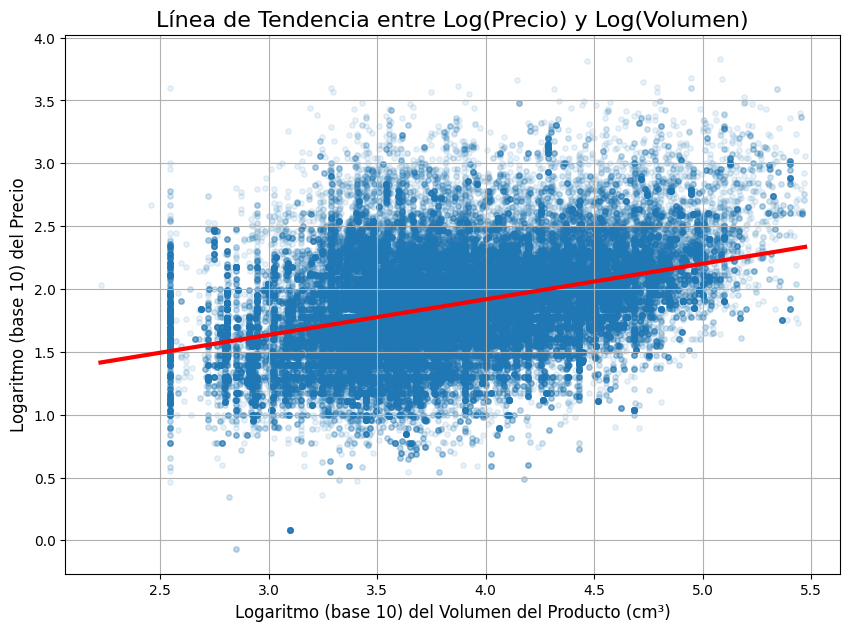

In [28]:
df_plot['log_precio'] = np.log10(df_plot['precio'])
df_plot['log_volumen'] = np.log10(df_plot['volumen_cm3'])

plt.figure(figsize=(10, 7))

# Usamos regplot sobre los datos transformados
# scatter_kws={'alpha':0.1} hace los puntos aún más transparentes
sns.regplot(data=df_plot, x='log_volumen', y='log_precio',
            scatter_kws={'alpha': 0.1, 's': 15},
            line_kws={'color': 'red', 'linewidth': 3})

plt.title('Línea de Tendencia entre Log(Precio) y Log(Volumen)', fontsize=16)
plt.xlabel('Logaritmo (base 10) del Volumen del Producto (cm³)', fontsize=12)
plt.ylabel('Logaritmo (base 10) del Precio', fontsize=12)
plt.grid(True)

plt.show()

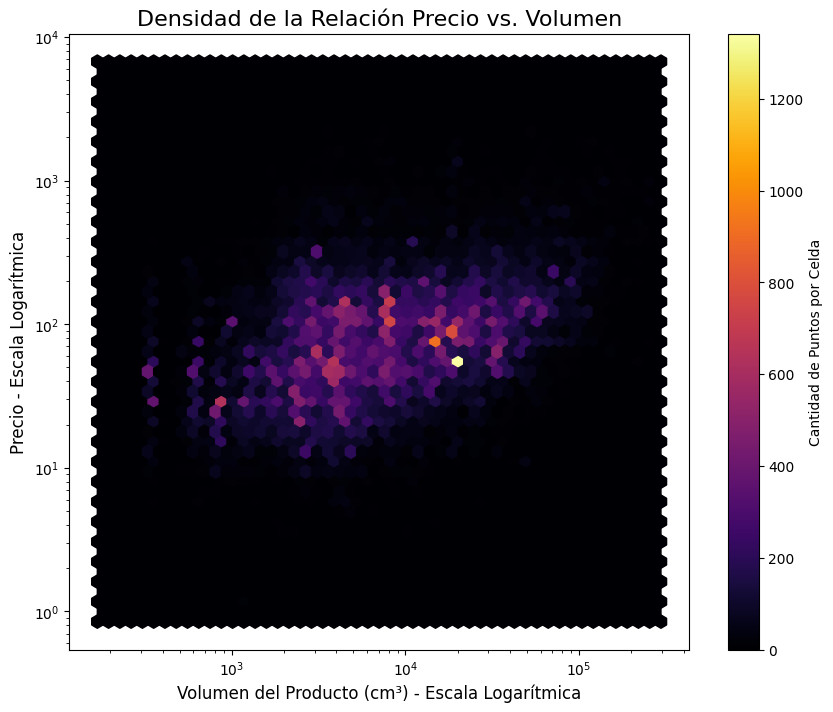

In [29]:
# Usaremos el DataFrame original filtrado
df_plot = merged_df[(merged_df['precio'] > 0) & (merged_df['volumen_cm3'] > 0)]

plt.figure(figsize=(10, 8))

# El gráfico hexbin agrupa los puntos en hexágonos y los colorea por densidad
plt.hexbin(x=df_plot['volumen_cm3'], y=df_plot['precio'],
           gridsize=50, cmap='inferno', xscale='log', yscale='log')

plt.colorbar(label='Cantidad de Puntos por Celda')
plt.title('Densidad de la Relación Precio vs. Volumen', fontsize=16)
plt.xlabel('Volumen del Producto (cm³) - Escala Logarítmica', fontsize=12)
plt.ylabel('Precio - Escala Logarítmica', fontsize=12)

plt.show()

In [30]:
df_plot["log_volumen"] = np.log10(df_plot["volumen_cm3"])

C:\Users\Diego\AppData\Local\Temp\ipykernel_6872\855083174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["log_volumen"] = np.log10(df_plot["volumen_cm3"])


In [31]:
df_plot["log_precio"] = np.log10(df_plot["precio"])

C:\Users\Diego\AppData\Local\Temp\ipykernel_6872\3694249815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["log_precio"] = np.log10(df_plot["precio"])


In [32]:
correlacion = df_plot['log_volumen'].corr(df_plot['log_precio'])

print(f"El Coeficiente de Correlación de Pearson (r) es: {correlacion:.4f}")

# También podemos calcular R-cuadrado (el Coeficiente de Determinación)
r_cuadrado = correlacion**2
print(f"R-cuadrado (R²) es: {r_cuadrado:.4f}")

El Coeficiente de Correlación de Pearson (r) es: 0.3924
R-cuadrado (R²) es: 0.1540


In [33]:
merged_df["cantidad_fotos_producto"]

0         4.0
1         4.0
2         4.0
3         1.0
4         1.0
         ... 
119138    4.0
119139    2.0
119140    1.0
119141    1.0
119142    1.0
Name: cantidad_fotos_producto, Length: 119143, dtype: float64

In [34]:
print(df_plot['cantidad_fotos_producto'].value_counts().sort_index())

cantidad_fotos_producto
1.0     58957
2.0     23054
3.0     12977
4.0      8863
5.0      5599
6.0      3945
7.0      1560
8.0       774
9.0       318
10.0      354
11.0       73
12.0       60
13.0       30
14.0        6
15.0       12
17.0       11
18.0        4
19.0        2
20.0        1
Name: count, dtype: int64


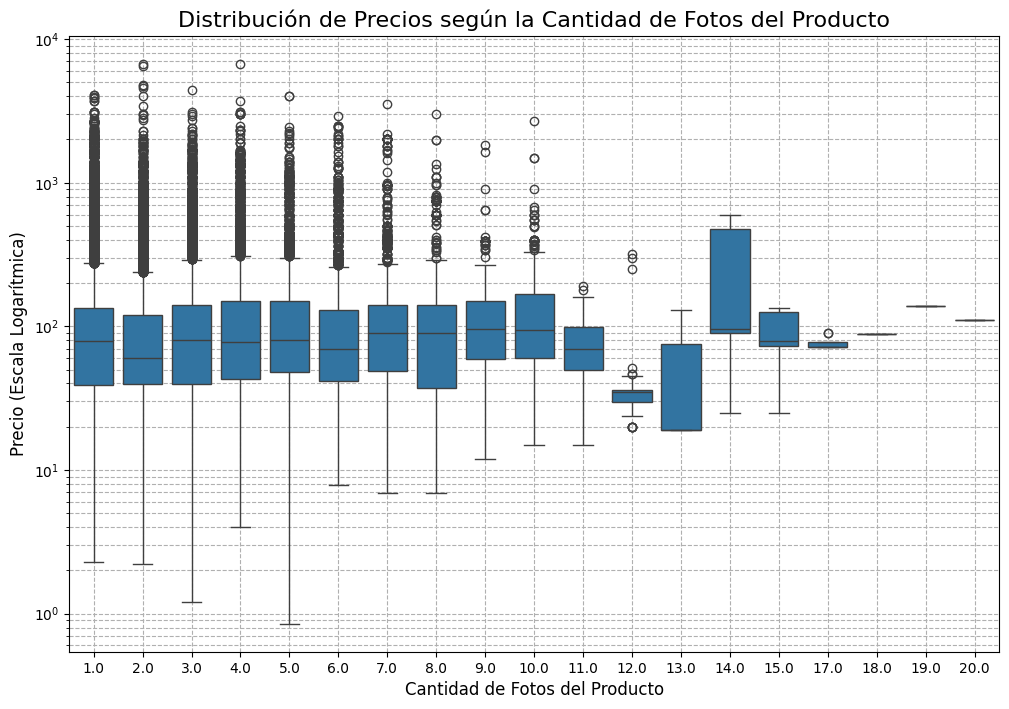

In [35]:
plt.figure(figsize=(12, 8)) # Un poco más grande para ver bien las cajas

# --- La Corrección Clave: Intercambiar 'x' e 'y' ---
sns.boxplot(data=df_plot, x='cantidad_fotos_producto', y='precio')

# --- Mejoras Adicionales ---
# Aplicamos escala logarítmica al eje de precios para una mejor visualización
plt.yscale('log')

# --- Títulos y Etiquetas Correctos ---
plt.title('Distribución de Precios según la Cantidad de Fotos del Producto', fontsize=16)
plt.xlabel('Cantidad de Fotos del Producto', fontsize=12)
plt.ylabel('Precio (Escala Logarítmica)', fontsize=12)
plt.grid(True, which="both", ls="--")

plt.show()

C:\Users\Diego\AppData\Local\Temp\ipykernel_6872\3178379521.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


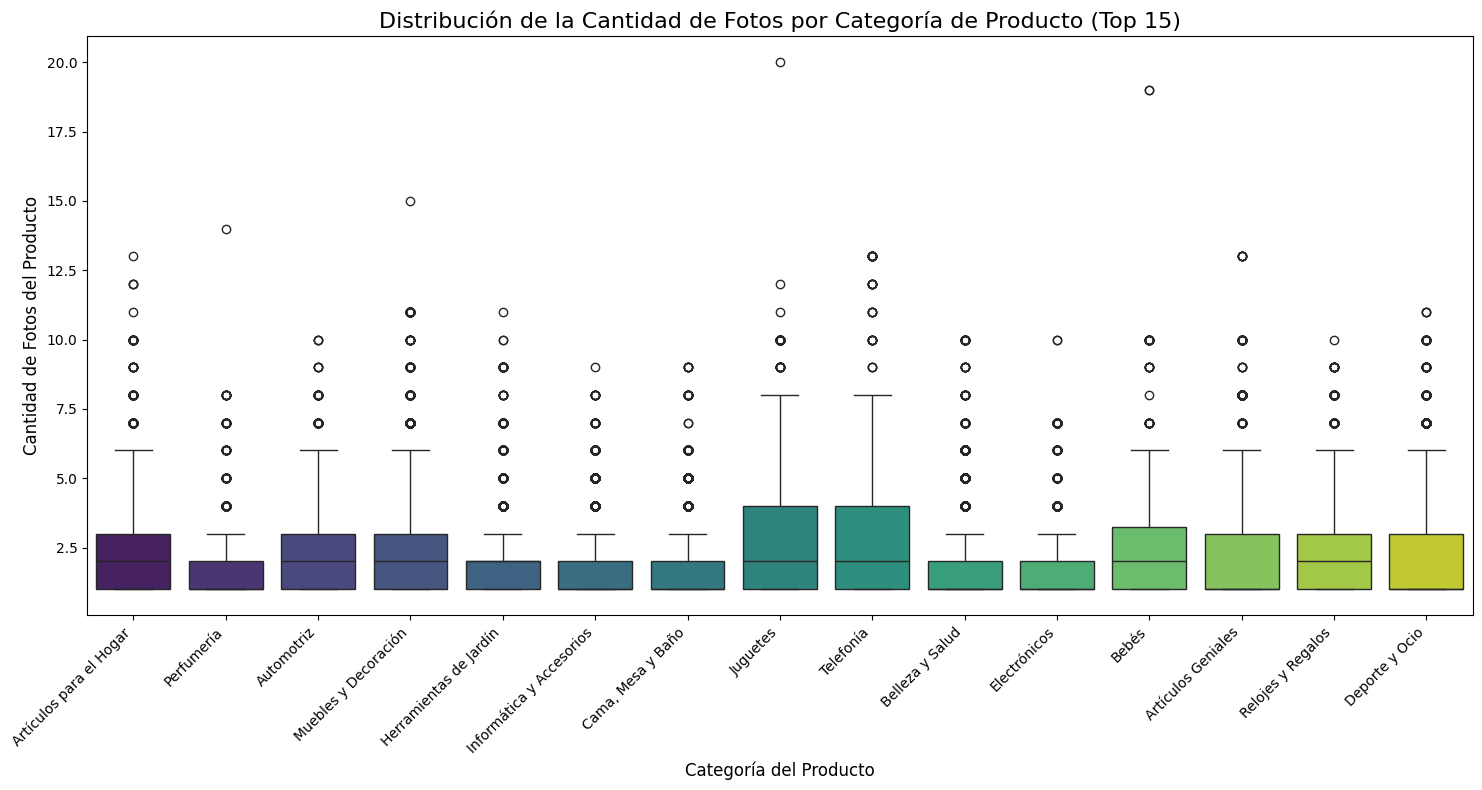

In [ ]:
top_15_categorias = merged_df['nombre_categoria_producto'].value_counts().nlargest(15).index

# --- PASO 2: Filtrar el DataFrame para quedarnos solo con esas categorías ---
df_top_categorias = merged_df[merged_df['nombre_categoria_producto'].isin(top_15_categorias)]


plt.figure(figsize=(15, 8)) # Hacemos el gráfico más ancho para que quepan las etiquetas

sns.boxplot(
    data=df_top_categorias,
    x='nombre_categoria_producto',
    y='cantidad_fotos_producto',
    palette='viridis' # Usamos una paleta de colores para diferenciar
)

# --- Títulos y Etiquetas ---
plt.title('Distribución de la Cantidad de Fotos por Categoría de Producto (Top 15)', fontsize=16)
plt.xlabel('Categoría del Producto', fontsize=12)
plt.ylabel('Cantidad de Fotos del Producto', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotamos las etiquetas para que no se superpongan
plt.tight_layout() # Ajusta el gráfico para que todo quepa bien

plt.show()

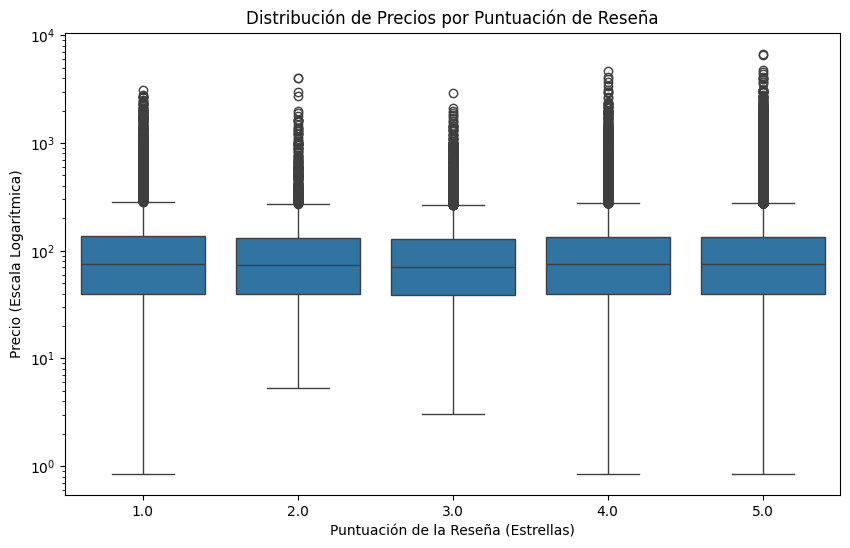

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='puntuacion_reseña', y='precio')
plt.yscale('log') # Usar escala logarítmica para el precio
plt.title('Distribución de Precios por Puntuación de Reseña')
plt.xlabel('Puntuación de la Reseña (Estrellas)')
plt.ylabel('Precio (Escala Logarítmica)')
plt.show()

In [39]:
# Asegurarse de que las columnas de fecha sean de tipo datetime
merged_df['fecha_compra'] = pd.to_datetime(merged_df['fecha_compra'])
merged_df['fecha_entrega_cliente'] = pd.to_datetime(merged_df['fecha_entrega_cliente'])

# Calcular la diferencia en días
merged_df['tiempo_entrega_dias'] = (merged_df['fecha_entrega_cliente'] - merged_df['fecha_compra']).dt.days

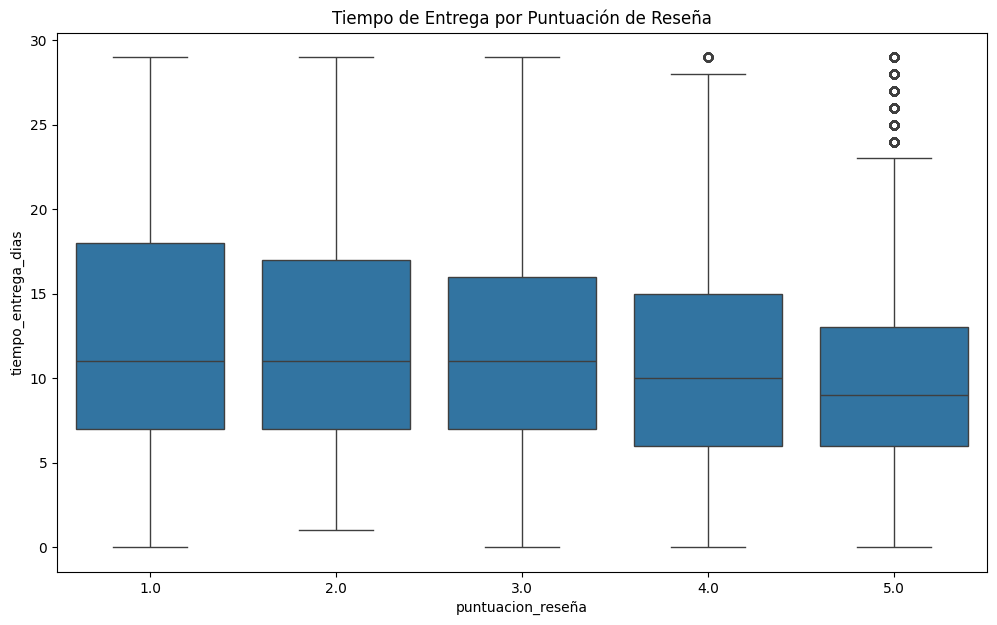

In [41]:
df_filtrado = merged_df[merged_df['tiempo_entrega_dias'] < 30] # Filtrar outliers de entrega muy largos
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_filtrado, x='puntuacion_reseña', y='tiempo_entrega_dias')
plt.title('Tiempo de Entrega por Puntuación de Reseña')
plt.show()

In [48]:
vendedores_stats = merged_df.groupby('id_vendedor').agg(
    # Agregamos el total de ventas (suma de precios)
    ventas_totales=('precio', 'sum'),
    
    # Contamos las órdenes únicas
    numero_ordenes_unicas=('id_pedido', 'nunique'),
    
    # Calculamos la puntuación promedio y el número de reseñas
    puntuacion_promedio=('puntuacion_reseña', 'mean'),
    numero_de_reseñas=('puntuacion_reseña', 'count'),

    # Calculamos el tiempo de entrega promedio
    tiempo_entrega_promedio=('tiempo_entrega_dias', 'mean')
    
).reset_index()

print("DataFrame de estadísticas de vendedores creado con éxito. Estas son sus columnas:")
print(vendedores_stats.columns)

DataFrame de estadísticas de vendedores creado con éxito. Estas son sus columnas:
Index(['id_vendedor', 'ventas_totales', 'numero_ordenes_unicas',
       'puntuacion_promedio', 'numero_de_reseñas', 'tiempo_entrega_promedio'],
      dtype='object')


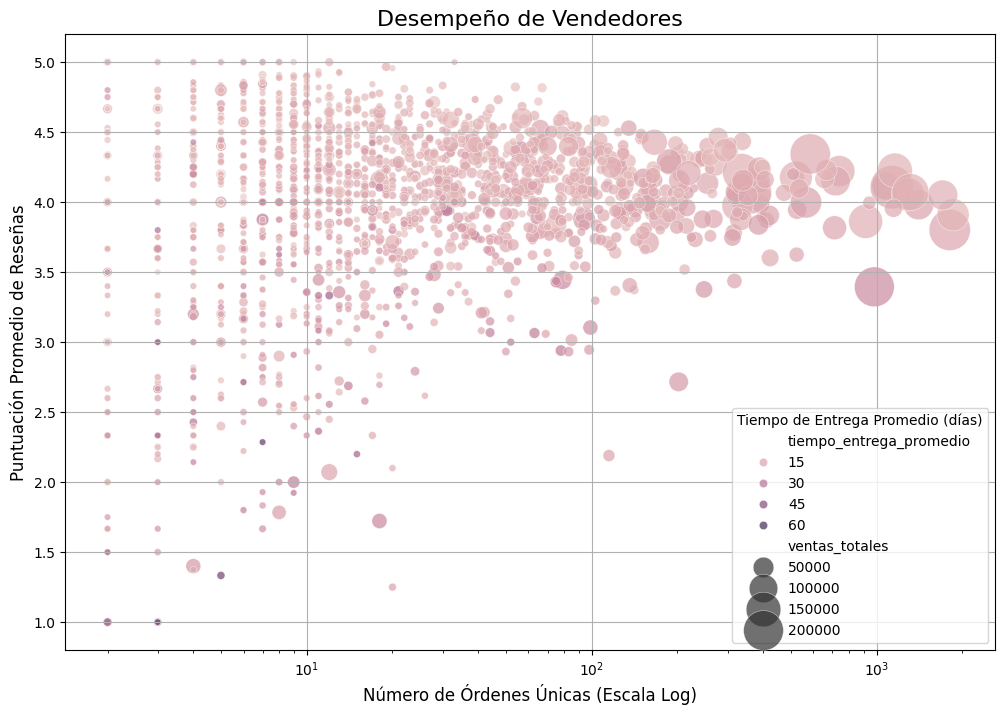

In [49]:
# Filtramos para tener datos más manejables en la visualización (opcional pero recomendado)
vendedores_plot = vendedores_stats[vendedores_stats['numero_ordenes_unicas'] > 1]

plt.figure(figsize=(12, 8))

# --- La Corrección ---
# Usamos los nombres de columna correctos que creamos en el paso anterior
sns.scatterplot(data=vendedores_plot,
                x='numero_ordenes_unicas',      # En lugar de 'numero_pedidos'
                y='puntuacion_promedio',
                size='ventas_totales',         # 'ventas_totales' ahora existe
                hue='tiempo_entrega_promedio',
                sizes=(20, 1000),             # Controla el rango de tamaño de las burbujas
                alpha=0.7)

plt.xscale('log')
plt.title('Desempeño de Vendedores', fontsize=16)
plt.xlabel('Número de Órdenes Únicas (Escala Log)', fontsize=12)
plt.ylabel('Puntuación Promedio de Reseñas', fontsize=12)
plt.legend(title='Tiempo de Entrega Promedio (días)')
plt.grid(True)

plt.show()

In [50]:
fecha_analisis = merged_df['fecha_compra'].max() + pd.Timedelta(days=1)

# Agrupamos por cliente único y calculamos sus métricas clave
clientes_df = merged_df.groupby('id_unico_cliente').agg(
    # Frecuencia: ¿Cuántas órdenes distintas ha hecho?
    frecuencia=('id_pedido', 'nunique'),
    
    # Monetario: ¿Cuánto ha gastado en total?
    gasto_total=('valor_pago', 'sum'),
    
    # Recencia: ¿Cuántos días han pasado desde su última compra?
    dias_desde_ultima_compra=('fecha_compra', lambda fecha: (fecha_analisis - fecha.max()).days),
    
    # Diversidad: ¿De cuántas categorías distintas ha comprado? (Tu pregunta clave)
    categorias_distintas=('nombre_categoria_producto', 'nunique')
).reset_index()

print("Perfil de clientes creado con éxito. Así se ve:")
display(clientes_df.head())

Perfil de clientes creado con éxito. Así se ve:


In [51]:
clientes_df

,id_unico_cliente,frecuencia,gasto_total,dias_desde_ultima_compra,categorias_distintas
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,161,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,164,1
2,0000f46a3911fa3c0805444483337064,1,86.22,586,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,370,1
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,337,1
...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,4134.84,496,1
96092,fffea47cd6d3cc0a88bd621562a9d061,1,84.58,311,1
96093,ffff371b4d645b6ecea244b27531430a,1,112.46,618,1
96094,ffff5962728ec6157033ef9805bacc48,1,133.69,169,1


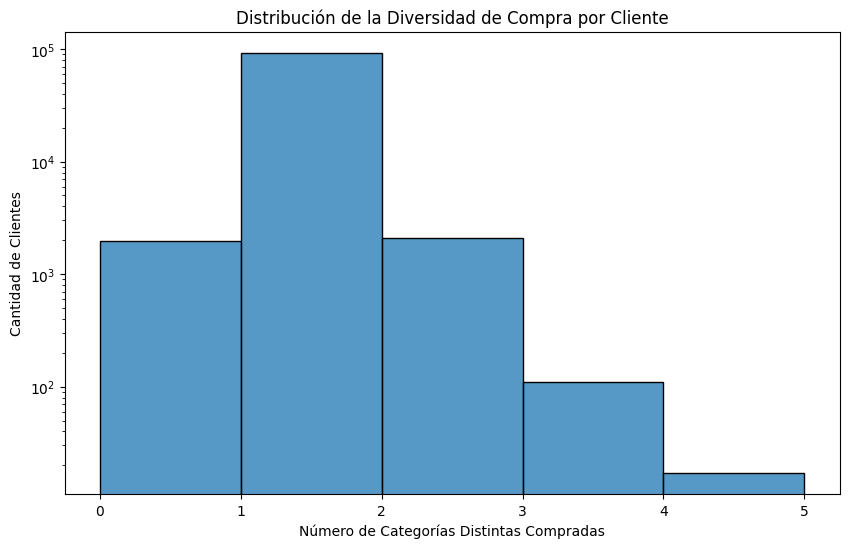

In [52]:
plt.figure(figsize=(10, 6))
sns.histplot(data=clientes_df, x='categorias_distintas', bins=clientes_df['categorias_distintas'].max())
plt.title('Distribución de la Diversidad de Compra por Cliente')
plt.xlabel('Número de Categorías Distintas Compradas')
plt.ylabel('Cantidad de Clientes')
plt.yscale('log') # Escala logarítmica para ver mejor los valores pequeños
plt.show()

In [53]:
# Asumiendo que 'merged_df' es tu DataFrame
# Nos aseguramos de que la fecha de compra sea de tipo datetime
merged_df['fecha_compra'] = pd.to_datetime(merged_df['fecha_compra'])

# Ordenamos los datos: primero por cliente, luego por fecha de compra
df_ordenado = merged_df.sort_values(by=['id_unico_cliente', 'fecha_compra'])

In [55]:
# Creamos una columna que contiene la fecha de la compra anterior para cada cliente
df_ordenado['fecha_compra_anterior'] = df_ordenado.groupby('id_unico_cliente')['fecha_compra'].shift(1)

# Calculamos la diferencia en días entre la compra actual y la anterior
df_ordenado['dias_entre_compras'] = (df_ordenado['fecha_compra'] - df_ordenado['fecha_compra_anterior']).dt.days

# Veamos el resultado. Las primeras compras de cada cliente tendrán 'NaN'
print("DataFrame con el cálculo de días entre compras:")
display(df_ordenado[['id_unico_cliente', 'fecha_compra', 'fecha_compra_anterior', 'dias_entre_compras']].info())

DataFrame con el cálculo de días entre compras:
<class 'pandas.core.frame.DataFrame'>
Index: 119143 entries, 63195 to 83699
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id_unico_cliente       119143 non-null  object        
 1   fecha_compra           119143 non-null  datetime64[ns]
 2   fecha_compra_anterior  23047 non-null   datetime64[ns]
 3   dias_entre_compras     23047 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 4.5+ MB


None

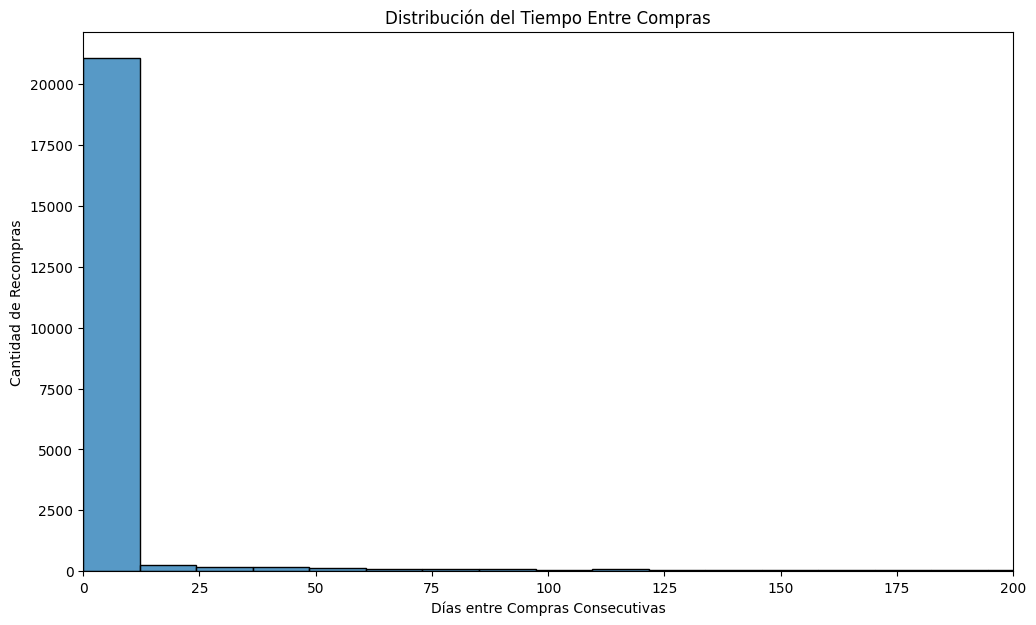

In [56]:
dias_validos = df_ordenado.dropna(subset=['dias_entre_compras'])

plt.figure(figsize=(12, 7))
sns.histplot(data=dias_validos, x='dias_entre_compras', bins=50)
plt.title('Distribución del Tiempo Entre Compras')
plt.xlabel('Días entre Compras Consecutivas')
plt.ylabel('Cantidad de Recompras')
# Es posible que quieras limitar el eje x para una mejor vista, ej. plt.xlim(0, 200)
plt.xlim(0, 200)

plt.show()

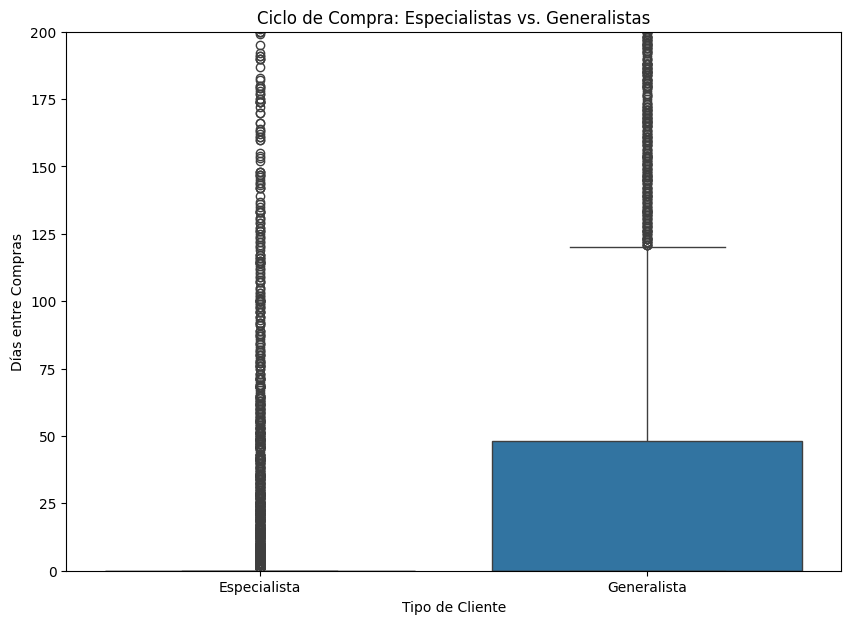

In [58]:
clientes_df['tipo_cliente'] = np.where(clientes_df['categorias_distintas'] > 1, 'Generalista', 'Especialista')

df_final = pd.merge(df_ordenado, clientes_df[['id_unico_cliente', 'tipo_cliente']], on='id_unico_cliente', how='left')

# Ahora creamos el box plot
plt.figure(figsize=(10, 7))
sns.boxplot(data=df_final, x='tipo_cliente', y='dias_entre_compras')
plt.title('Ciclo de Compra: Especialistas vs. Generalistas')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Días entre Compras')
plt.ylim(0, 200) # Limitamos el eje y para una mejor visualización
plt.show()

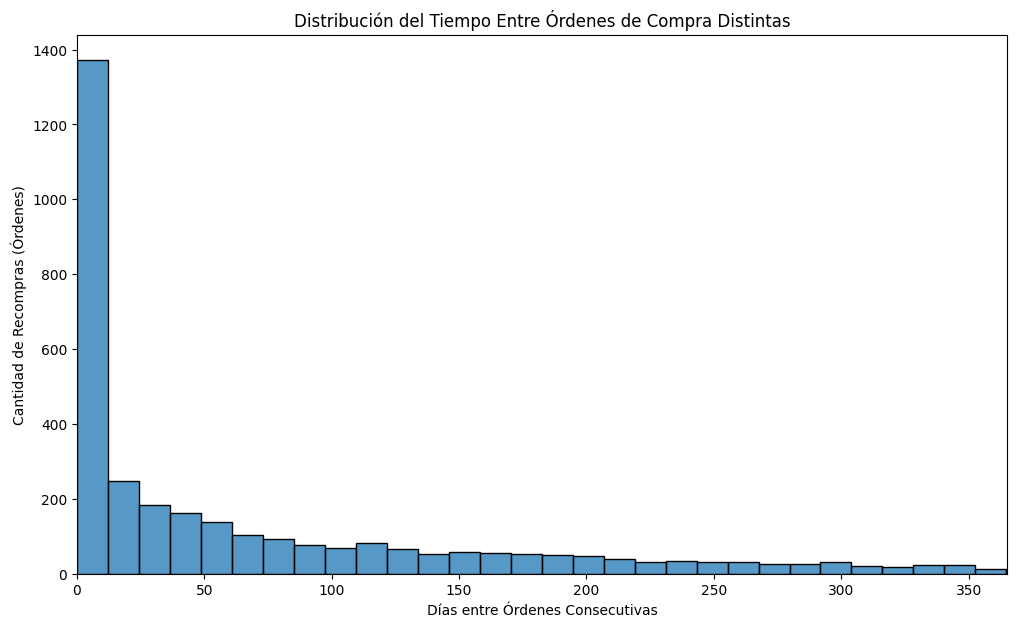

In [59]:
ordenes_df = merged_df.groupby(['id_unico_cliente', 'id_pedido'])['fecha_compra'].min().reset_index()


# --- PASO 2: Repetir el cálculo del ciclo de compra, pero sobre las ÓRDENES ---
# Ordenamos por cliente y fecha de la orden
ordenes_df_sorted = ordenes_df.sort_values(by=['id_unico_cliente', 'fecha_compra'])

# Calculamos la fecha de la ORDEN anterior
ordenes_df_sorted['fecha_orden_anterior'] = ordenes_df_sorted.groupby('id_unico_cliente')['fecha_compra'].shift(1)

# Calculamos los días entre ÓRDENES distintas
ordenes_df_sorted['dias_entre_ordenes'] = (ordenes_df_sorted['fecha_compra'] - ordenes_df_sorted['fecha_orden_anterior']).dt.days


# --- PASO 3: Graficar el nuevo resultado ---
# Filtramos los NaT (primera orden de cada cliente)
dias_entre_ordenes_validos = ordenes_df_sorted.dropna(subset=['dias_entre_ordenes'])

plt.figure(figsize=(12, 7))
sns.histplot(data=dias_entre_ordenes_validos, x='dias_entre_ordenes', bins=50)
plt.title('Distribución del Tiempo Entre Órdenes de Compra Distintas')
plt.xlabel('Días entre Órdenes Consecutivas')
plt.ylabel('Cantidad de Recompras (Órdenes)')
plt.xlim(0, 365) # Ampliamos la vista a un año completo

plt.show()

In [60]:
merged_df['fecha_compra'] = pd.to_datetime(merged_df['fecha_compra'])
df_tiempo = merged_df.set_index('fecha_compra')

# 2. Reagrupar los datos por mes ('M')
#    Calculamos los ingresos totales (suma de valor_pago) y el número de órdenes
ventas_mensuales = df_tiempo.resample('M').agg(
    ingresos_totales=('valor_pago', 'sum'),
    numero_ordenes=('id_pedido', 'nunique')
)

print("Datos de ventas agregados por mes:")
display(ventas_mensuales.head())

C:\Users\Diego\AppData\Local\Temp\ipykernel_6872\2616470228.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ventas_mensuales = df_tiempo.resample('M').agg(


Datos de ventas agregados por mes:


,ingresos_totales,numero_ordenes
fecha_compra,,
2016-09-30,388.47,4
2016-10-31,76559.05,324
2016-11-30,0.00,0
2016-12-31,19.62,1
2017-01-31,190806.27,800


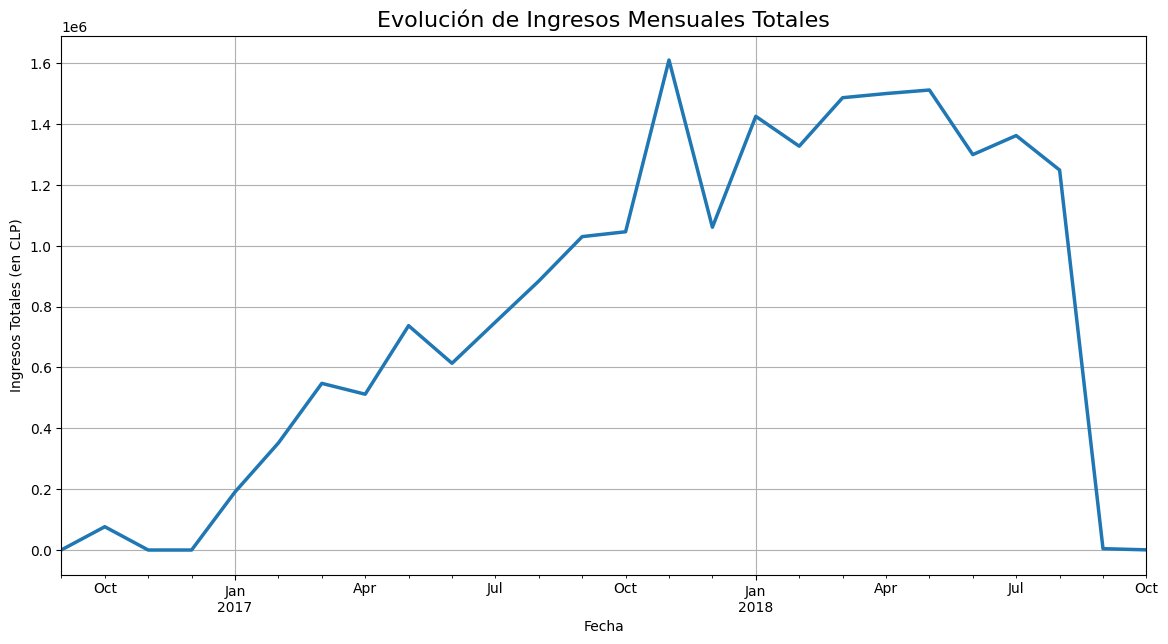

In [61]:
plt.figure(figsize=(14, 7))
ventas_mensuales['ingresos_totales'].plot(linewidth=2.5)
plt.title('Evolución de Ingresos Mensuales Totales', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Ingresos Totales (en CLP)')
plt.grid(True)
plt.show()

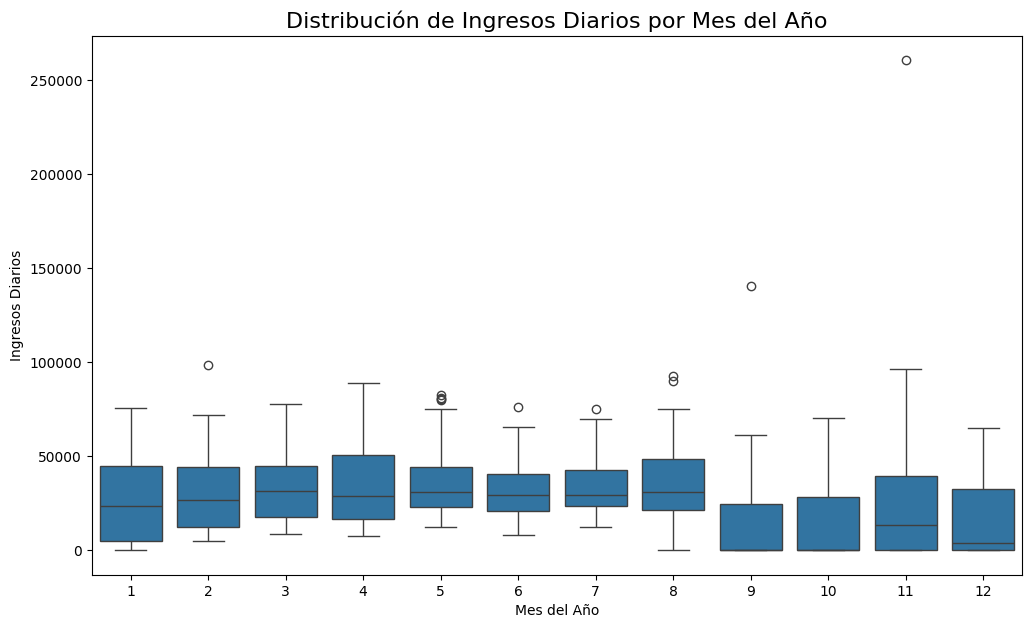

In [62]:
ventas_diarias = df_tiempo.resample('D').agg(ingresos_totales=('valor_pago', 'sum'))
ventas_diarias['mes'] = ventas_diarias.index.month

plt.figure(figsize=(12, 7))
sns.boxplot(data=ventas_diarias, x='mes', y='ingresos_totales')
plt.title('Distribución de Ingresos Diarios por Mes del Año', fontsize=16)
plt.xlabel('Mes del Año')
plt.ylabel('Ingresos Diarios')
plt.show()

C:\Users\Diego\AppData\Local\Temp\ipykernel_6872\1001536605.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ventas_categoria_mensual = df_tiempo.groupby('nombre_categoria_producto').resample('M').agg(
C:\Users\Diego\AppData\Local\Temp\ipykernel_6872\1001536605.py:1: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ventas_categoria_mensual = df_tiempo.groupby('nombre_categoria_producto').resample('M').agg(


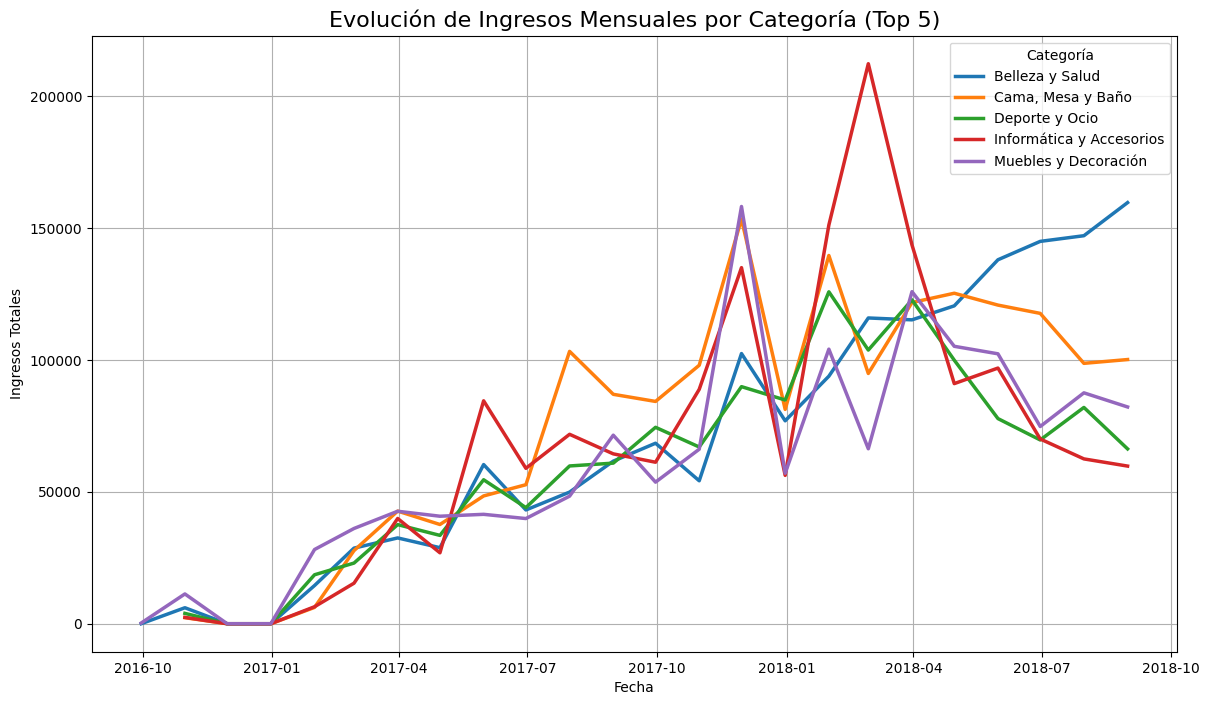

In [63]:
ventas_categoria_mensual = df_tiempo.groupby('nombre_categoria_producto').resample('M').agg(
    ingresos_totales=('valor_pago', 'sum')
).reset_index()

# Seleccionamos las top 5 categorías para que el gráfico sea legible
top_5_categorias = merged_df['nombre_categoria_producto'].value_counts().nlargest(5).index
df_top_5_plot = ventas_categoria_mensual[ventas_categoria_mensual['nombre_categoria_producto'].isin(top_5_categorias)]

# Creamos el gráfico de líneas comparativo
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_top_5_plot, x='fecha_compra', y='ingresos_totales', hue='nombre_categoria_producto', linewidth=2.5)
plt.title('Evolución de Ingresos Mensuales por Categoría (Top 5)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Ingresos Totales')
plt.legend(title='Categoría')
plt.grid(True)
plt.show()